In [10]:
import numpy as np
import tensorflow as tf
import t3f
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from TTGP.gpstruct import TTGPstruct
from TTGP import grid
from TTGP.covariance import SE_multidim, BinaryKernel
from TTGP.projectors import Identity
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

In [2]:
x_tr = np.load('data_struct_embed/x_tr.npy')
x_te = np.load('data_struct_embed/x_te.npy')
y_tr = np.load('data_struct_embed/y_tr.npy')
y_te = np.load('data_struct_embed/y_te.npy')

In [3]:
x_tr.shape

(100, 3, 2)

In [4]:
D = x_tr.shape[-1]

In [5]:
x_tr_flat = x_tr.reshape([-1, D])
x_te_flat = x_te.reshape([-1, D])

In [6]:
scaler = StandardScaler()
x_tr_flat = scaler.fit_transform(x_tr_flat)/3
x_te_flat = scaler.transform(x_te_flat)/3

In [7]:
x_tr = x_tr_flat.reshape(x_tr.shape)
x_te = x_te_flat.reshape(x_te.shape)

In [8]:
x_tr[x_tr > 1] = 1
x_tr[x_tr < -1] = -1
x_te[x_te > 1] = 1
x_te[x_te < -1] = -1

In [9]:
max_len = x_tr.shape[1]
n_labels = 4
n_seq = x_tr.shape[0]

## GP

In [13]:
tf.reset_default_graph()

In [14]:
num = 10
inputs = grid.InputsGrid(D, left=-1., right=1., npoints=num)
projector = Identity(D)
cov = SE_multidim(n_labels, .7, .3, .1, projector)
cov_bin = BinaryKernel(n_labels, 1.)

In [17]:
mu_ranks = 5
gp = TTGPstruct(cov, cov_bin, inputs, mu_ranks)

## Graph Creation

In [18]:
seq_lens = np.ones(shape=(n_seq,)) * max_len

In [19]:
x_tr = tf.constant(x_tr)
x_te = tf.constant(x_te)
y_tr = tf.constant(y_tr)
y_te = tf.constant(y_te)
seq_lens = tf.constant(seq_lens)

In [20]:
N = n_seq
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(1e-2, global_step, 
                                        50, 0.5, staircase=True)

In [28]:
elbo_op, train_op = gp.fit(x_tr, y_tr, seq_lens, N, lr, global_step)

_latent_vars_distribution/x_flat (?, 2) = sum_len x 2
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 4
cov_for_squared_dists/cov (4, 100, 3, 3) = [4, 100, 3, 3]
_Knns/K_nn (4, 100, 3, 3) = 4 x 100 x 3 x 3
_sample_f/f_un (4, 100, 3) = 4 100 3
_sample_f/f_bin (16,) = 16


## Learning

In [29]:
sess = tf.Session()
gp.initialize(sess)
sess.run(tf.global_variables_initializer())

In [30]:
maxiter = 300
elbo_vals = []
for i in range(maxiter):
    _, elbo = sess.run([train_op, elbo_op])
    print(elbo)
    elbo_vals.append(elbo)

18229.7518925
17605.7518204
16716.6196479
16015.2572985
15251.2182545
14541.0615795
13909.4636342
13300.8856197
12704.3845934
12151.1872072
11642.2109216
11155.3933918
10679.9917525
10226.4467823
9808.32889676
9421.55902769
9055.0373137
8698.79272085
8356.93408154
8036.40231266
7735.8592038
7453.86227184
7183.56238411
6924.79948597
6677.74822032
6443.62109657
6222.89103051
6012.61838534
5812.40714496
5619.85700309
5436.76806094
5263.26635327
5098.03120001
4939.80824917
4785.27223811
4639.36775689
4501.69756435
4370.35287057
4242.09420692
4120.46105061
4001.82205242
3888.83608466
3780.66751238
3676.52325681
3577.00719288
3478.38150348
3386.4732077
3298.68878527
3211.52721993
3128.86547209
3047.72353658
3009.34857085
2970.68740916
2934.08096418
2896.58728742
2860.48604139
2824.99477811
2792.3444778
2758.94714753
2724.95976386
2691.86924395
2659.71466358
2628.65518491
2597.87017461
2566.59859159
2536.65452961
2508.84661653
2477.85695934
2449.86581203
2421.86180553
2392.73176198
2364.82756

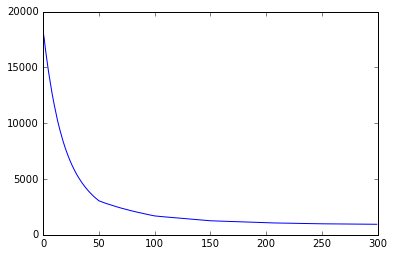

In [31]:
plt.plot(elbo_vals)

In [32]:
bin_mu = sess.run(gp.bin_mu)

In [33]:
for i in range(4):
    for j in range(4):
        print(i, j, bin_mu[i * 4 + j])

0 0 0.553963349399
0 1 0.39480641395
0 2 -0.597278915372
0 3 -0.601571429237
1 0 -0.597469475901
1 1 0.55977920358
1 2 0.553882967739
1 3 -0.539256871739
2 0 -0.596028123687
2 1 -0.619830593967
2 2 0.187698606715
2 3 0.463974380524
3 0 0.518718271468
3 1 -0.639396412764
3 2 -0.654174412635
3 3 0.435911978393


## Prediction

In [34]:
seq_lens_te = tf.constant(np.ones([x_te.shape[0]]) * max_len)

In [35]:
preds = gp.predict(x_te, seq_lens_te, sess)

_latent_vars_distribution/x_flat (?, 2) = sum_len x 2
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 4
cov_for_squared_dists/cov (4, 50, 3, 3) = [4, 50, 3, 3]
_Knns/K_nn (4, 50, 3, 3) = 4 x 50 x 3 x 3


In [38]:
sess.close()